# Memory Based Classification with QKM

A memory based classifier with  [Quantum kernel Mixtures](https://github.com/fagonzalezo/quakemix).

In [1]:
'''
Create a 2 moons dataset 
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


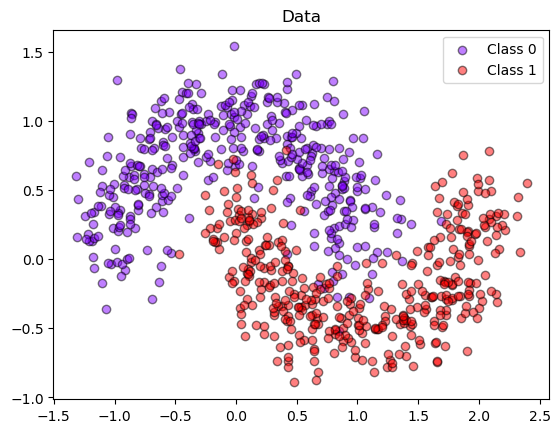

In [24]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun_mem(clf):
    def pred_fun(X):
        X_ds = clf.create_predict_ds(X)
        return clf.predict(X_ds)[:, 1]
    return pred_fun

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

plot_data(X_train, y_train)

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics
import tensorflow as tf

import qkm
from importlib import reload
reload(qkm);
reload(qkm.tf.layers.rbf_kernel_layer);reload(qkm.tf.layers.qkm_layer);
reload(qkm.tf.layers.mem_qkm_layer);reload(qkm.tf.models.mem_qkm_class_model);
reload(qkm.tf.layers);reload(qkm.tf.models);

## Memory QKM Model

First we pretrain a QKM Model for a few epochs and use the learned encoder for a Memory Based QKM Classifier.

In [20]:
from qkm.tf.models import MemQKMClassModel, QKMClassModel


encoded_size = 10
dim_y = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(encoded_size, activation='linear', input_shape=(2,)),
])  
n_comp = 20

qkm_model = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=1.)

qkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
idx = np.random.randint(X_train.shape[0], size=n_comp)
qkm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)
print(f"Initial sigma: {qkm_model.kernel.sigma.numpy()}")
qkm_model.fit(X_train, y_train, epochs=2, batch_size=32)
print(f"FInal sigma: {qkm_model.kernel.sigma.numpy()}")


Initial sigma: 0.7800304889678955
Epoch 1/2


2023-08-21 10:37:48.120556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 2s 43ms/step - loss: 0.3615 - sparse_categorical_accuracy: 0.8350
Epoch 2/2
25/25 [==============================] - 1s 25ms/step - loss: 0.3034 - sparse_categorical_accuracy: 0.8587
FInal sigma: 0.7317646145820618


We evaluate the performance of the classifier on the test set.

In [21]:
score = qkm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = qkm_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

2023-08-21 10:37:53.170053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.2838107645511627
Test accuracy: 0.8650000095367432
Train loss: 0.2787265479564667
Train accuracy: 0.8712499737739563


2023-08-21 10:40:39.935920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 15ms/step
0.0010316691 0.0010316691


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


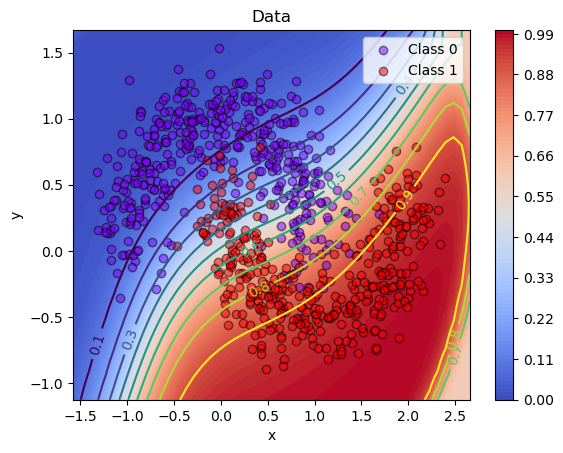

In [25]:
plot_decision_region(X, gen_pred_fun(qkm_model))
plot_data(X_train, y_train)


Since the model is trained for few epochs, the performance is not very good. Now we use the same encoder with a Memory Based QKM Classifier.

In [38]:
from qkm.tf.models import MemQKMClassModel, QKMClassModel


encoded_size = 10
dim_y = 2
n_comp = 50

mqkm_model = MemQKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=qkm_model.kernel.sigma.numpy())

# init the memory
mqkm_model.create_index(X_train, np.eye(dim_y)[y_train])
X_train_ds = mqkm_model.create_train_ds(batch_size=32)
X_test_ds = mqkm_model.create_test_ds(X_test, np.eye(dim_y)[y_test], batch_size=32)
X_pred_ds = mqkm_model.create_predict_ds(X_test)

# train the classifier
mqkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mqkm_model.kernel.sigma.numpy()}")

2023-08-21 10:45:59.308872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Initial sigma: 0.7317646145820618


In [39]:
from sklearn.metrics import accuracy_score
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y = mqkm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

2023-08-21 10:46:04.421824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-21 10:46:04.437609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-21 10:46:04.863882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.09216485917568207
Test accuracy: 0.9700000286102295


2023-08-21 10:46:05.937689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.97


In [40]:
from sklearn.metrics import accuracy_score
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y = mqkm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

Test loss: 0.09216485917568207
Test accuracy: 0.9700000286102295
Accuracy: 0.97


16/79 [=====>........................] - ETA: 0s

2023-08-21 10:46:12.139096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 8ms/step
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


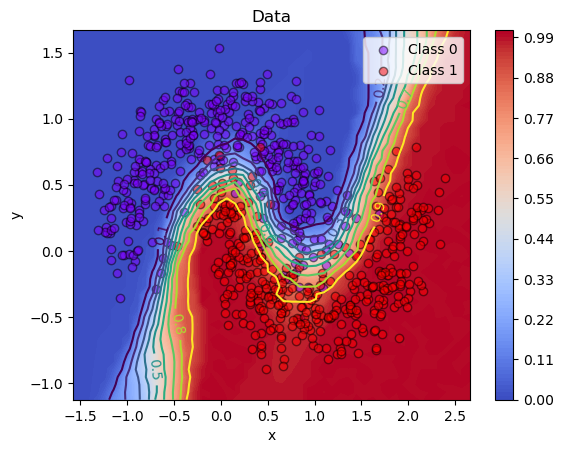

In [41]:
plot_decision_region(X, gen_pred_fun_mem(mqkm_model))
plot_data(X_train, y_train)


The performance is much better. We can fine tune the sigma parameter.

In [42]:

# train the classifier
mqkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mqkm_model.kernel.sigma.numpy()}")
mqkm_model.fit(X_train_ds, epochs=5, verbose=1)
print(f"FInal sigma: {mqkm_model.kernel.sigma.numpy()}")


Initial sigma: 0.7317646145820618
Epoch 1/5


2023-08-21 10:46:24.436871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 3s 54ms/step - loss: 0.1022 - categorical_accuracy: 0.9650
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 0.1022 - categorical_accuracy: 0.9650
Epoch 3/5
25/25 [==============================] - 1s 21ms/step - loss: 0.1022 - categorical_accuracy: 0.9650
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 0.1021 - categorical_accuracy: 0.9650
Epoch 5/5
25/25 [==============================] - 1s 20ms/step - loss: 0.1021 - categorical_accuracy: 0.9650
FInal sigma: 0.6527519822120667


2023-08-21 10:46:32.810333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.09174356609582901
Test accuracy: 0.9750000238418579


2023-08-21 10:46:33.875537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.975
12/79 [===>..........................] - ETA: 0s

2023-08-21 10:46:34.417219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 9ms/step
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


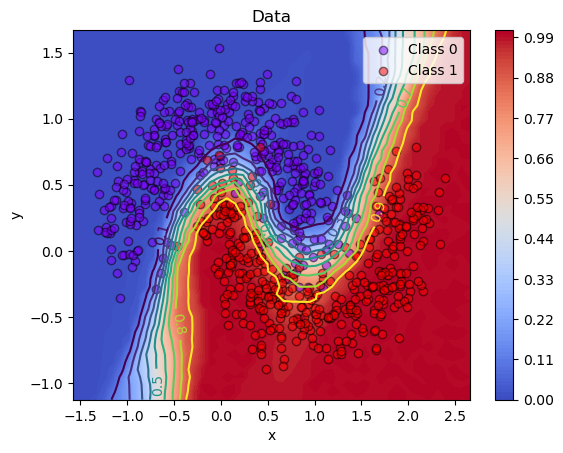

In [43]:
from sklearn.metrics import accuracy_score
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y = mqkm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

plot_decision_region(X, gen_pred_fun_mem(mqkm_model))
plot_data(X_train, y_train)


## MNIST example

An example using the mnist dataset. In addition to perform classification we will show how to perform generation.

In [32]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics
import qkm
import tensorflow as tf

from importlib import reload
reload(qkm);

In [33]:
# Create a dataset from mnist using tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.95, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [34]:
tfkl = tf.keras.layers

def create_encoder(input_shape, base_depth, encoded_size, l2_reg=0.):
    encoder = tf.keras.Sequential([
        tfkl.InputLayer(input_shape=input_shape),
        tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=tf.nn.leaky_relu),
        (tfkl.Dense(encoded_size, activation=None) if l2_reg == 0.
         else   tfkl.Dense(encoded_size, 
                           activation=None, 
                           activity_regularizer=tf.keras.regularizers.l2(1e-3))),
        tfkl.Flatten(),
    ])
    return encoder

The classifier model (QKMClassModel) receives as input the encoder, and applies it before applying the QKM inference layer.

In [35]:
from qkm.tf.models import QKMClassModel, MemQKMClassModel
# Define the encoder
input_shape = (28, 28, 1)
base_depth = 32
encoded_size = 32
encoder1 = create_encoder(input_shape, base_depth, encoded_size, l2_reg=1e-3)

# warm up the encoder
enc_model = tf.keras.Sequential([encoder1,
                tf.keras.layers.Dense(10, activation='softmax')])
enc_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])
enc_model.fit(X_train, y_train, epochs=1, batch_size=128)

score = enc_model.evaluate(X_test, y_test, verbose=0)
print('Base encoder test loss:', score[0])
print('Base encoder test accuracy:', score[1])
score = enc_model.evaluate(X_train, y_train, verbose=0)
print('Base encoder train loss:', score[0])
print('Base encoder train accuracy:', score[1])


# Create a classifier model
dim_y = 10
n_comp = 64

qkm_mnist = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder1,
                            n_comp=n_comp,        
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
qkm_mnist.init_components(X_train[idx], tf.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=0.1)

print(f'Sigma: {qkm_mnist.kernel.sigma.numpy()}')

# Compile the model
qkm_mnist.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = qkm_mnist.evaluate(X_test, y_test, verbose=0)
print('QKM test loss:', score[0])
print('QKM test accuracy:', score[1])
score = qkm_mnist.evaluate(X_train, y_train, verbose=0)
print('QKM train loss:', score[0])
print('QKM train accuracy:', score[1])
print(f'Sigma: {qkm_mnist.kernel.sigma.numpy()}')

2023-08-23 12:30:53.844620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 2s 46ms/step - loss: 1.1077 - sparse_categorical_accuracy: 0.6607


2023-08-23 12:30:55.564767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Base encoder test loss: 0.510054886341095
Base encoder test accuracy: 0.8758000135421753


Base encoder train loss: 0.46502721309661865
Base encoder train accuracy: 0.8826666474342346
Sigma: 1.0431658029556274


2023-08-23 12:31:00.343126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


QKM test loss: 1.3179340362548828
QKM test accuracy: 0.6212000250816345
QKM train loss: 1.256537914276123
QKM train accuracy: 0.6480000019073486
Sigma: 1.0431658029556274


In [5]:
# Train the model
qkm_mnist.fit(X_train, y_train, validation_data=(X_val[:1000], y_val[:1000]), epochs=5, batch_size=128, verbose=1)
print(f'Final Sigma: {qkm_mnist.kernel.sigma.numpy()}')


Epoch 1/5


2023-08-22 11:26:02.286036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 3s 95ms/step - loss: 0.3945 - sparse_categorical_accuracy: 0.8907 - val_loss: 0.3766 - val_sparse_categorical_accuracy: 0.9040
Epoch 2/5
24/24 [==============================] - 2s 66ms/step - loss: 0.2254 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.3254 - val_sparse_categorical_accuracy: 0.9250
Epoch 3/5
24/24 [==============================] - 2s 64ms/step - loss: 0.1574 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.2617 - val_sparse_categorical_accuracy: 0.9390
Epoch 4/5
24/24 [==============================] - 2s 64ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.2679 - val_sparse_categorical_accuracy: 0.9370
Epoch 5/5
24/24 [==============================] - 2s 64ms/step - loss: 0.1222 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.2428 - val_sparse_categorical_accuracy: 0.9450
Final Sigma: 0.9933825135231018


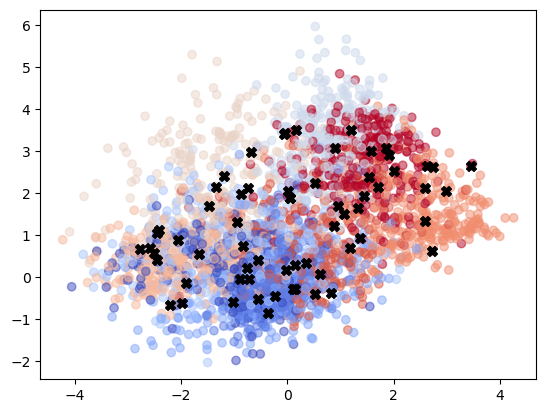

In [36]:
import matplotlib.pyplot as plt
# Visualize the points in the feature space
plt.scatter(encoder1(X_train)[:, 0], encoder1(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(qkm_mnist.qkm.c_x.numpy()[:, 0], qkm_mnist.qkm.c_x.numpy()[:, 1], c='k', marker='X', s=50)
plt.show()

The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses. Note that the prototypes do not cover all the areas of the different classes in the latent space, rather they are positioned to maximize the classification performance.

In [28]:
# Evaluate the classifier
score = qkm_mnist.evaluate(X_test, y_test, verbose=0)
print('QKM Test loss:', score[0])
print('QKM Test accuracy:', score[1])
score = qkm_mnist.evaluate(X_train, y_train, verbose=0)
print('QKM Train loss:', score[0])
print('QKM Train accuracy:', score[1])
print(f'QKM Sigma: {qkm_mnist.kernel.sigma.numpy()}')

QKM Test loss: 0.2824394404888153
QKM Test accuracy: 0.991100013256073
QKM Train loss: 0.2561342418193817
QKM Train accuracy: 0.999833345413208
QKM Sigma: 7.3804240226745605


Now we will train a density estimation model using the QKMJointDenEstModel class and keeping the encoder fix. This model maximizes the joint likelihood of inputs and outputs. The goal is to obtain more representative prototypes, since the prototypes learned using the classification model are not representative of the data distribution, since them are optimized to maximize the classification accuracy.

In [12]:
X_train.shape

(3000, 28, 28, 1)

In [37]:
n_comp = 200
encoder2 = create_encoder(input_shape, base_depth, encoded_size)
encoder2.set_weights(encoder1.get_weights())

mqkm_model = MemQKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder2,
                            n_comp=n_comp,
                            sigma=qkm_mnist.kernel.sigma.numpy())

# init the memory
mqkm_model.create_index(X_train, np.eye(10)[y_train])
X_train_ds = mqkm_model.create_train_ds(batch_size=32)
X_test_ds = mqkm_model.create_test_ds(X_test, np.eye(10)[y_test], batch_size=32)
X_pred_ds = mqkm_model.create_predict_ds(X_test)

mqkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])

2023-08-23 12:32:13.134206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [38]:
scores = []
mult = [2 ** i for i in range(-5, 4, 1)]
for m in mult:
    mqkm_model.kernel.sigma.assign(qkm_mnist.kernel.sigma.numpy() * m)
    score = mqkm_model.evaluate(X_test_ds, verbose=0)
    print(mqkm_model.kernel.sigma.numpy())
    print('Mem QKM Test loss:', score[0])
    print('Mem QKM Test accuracy:', score[1])
    scores.append(score)


2023-08-23 12:32:42.007336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 12:32:42.028073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 12:32:42.246741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.03259893
Mem QKM Test loss: 0.5011695623397827
Mem QKM Test accuracy: 0.8532000184059143
0.06519786
Mem QKM Test loss: 0.501167893409729
Mem QKM Test accuracy: 0.8532000184059143
0.13039573
Mem QKM Test loss: 0.5011024475097656
Mem QKM Test accuracy: 0.8532000184059143
0.26079145
Mem QKM Test loss: 0.49434521794319153
Mem QKM Test accuracy: 0.8546000123023987
0.5215829
Mem QKM Test loss: 0.43256402015686035
Mem QKM Test accuracy: 0.8824999928474426
1.0431658
Mem QKM Test loss: 0.41673657298088074
Mem QKM Test accuracy: 0.9106000065803528
2.0863316
Mem QKM Test loss: 0.3196526765823364
Mem QKM Test accuracy: 0.9054999947547913
4.172663
Mem QKM Test loss: 0.43332457542419434
Mem QKM Test accuracy: 0.8729000091552734
8.345326
Mem QKM Test loss: 0.48389989137649536
Mem QKM Test accuracy: 0.8590999841690063


In [39]:
X_pred_ds[0].shape, X_pred_ds[1].shape
neigh_x =  tf.gather(mqkm_model.samples_x, X_pred_ds[1], axis=0)
# Calculate the distance between the query and the neighbors
dist = tf.norm(X_pred_ds[0][:, tf.newaxis, :] - neigh_x, axis=2)
# Calculate the average, min and max distance
avg_dist = tf.reduce_mean(dist, axis=1)
min_dist = tf.reduce_min(dist, axis=1)
max_dist = tf.reduce_max(dist, axis=1)
# plot a histogram of the distances


2023-08-23 12:34:20.068314: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


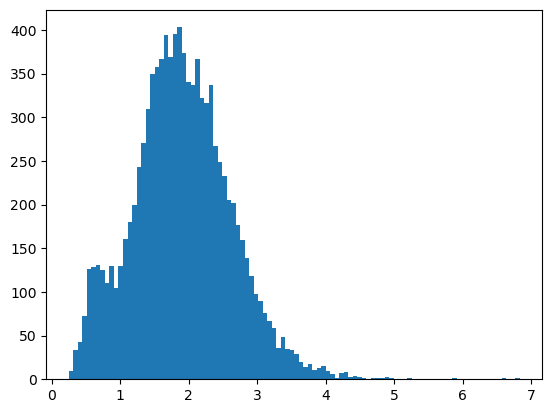

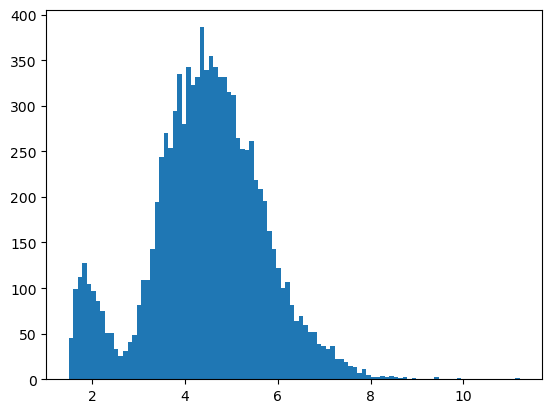

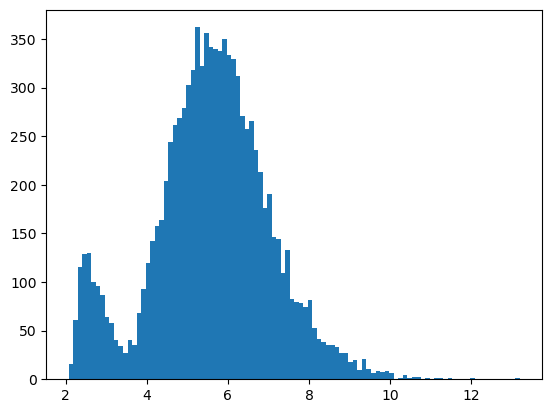

In [40]:
import matplotlib.pyplot as plt
plt.hist(min_dist.numpy(), bins=100)
plt.show()

plt.hist(avg_dist.numpy(), bins=100)
plt.show()

plt.hist(max_dist.numpy(), bins=100)
plt.show()


In [46]:

mqkm_model.kernel.sigma.assign(5)
mqkm_model.predict((X_pred_ds[0][0:2], X_pred_ds[1][0:2]) ,  verbose=0)

array([[0.        , 0.        , 0.        , 0.00313675, 0.        ,
        0.        , 0.        , 0.9840078 , 0.        , 0.01285542],
       [0.02424853, 0.00190944, 0.8127018 , 0.12876502, 0.        ,
        0.01581336, 0.00635682, 0.        , 0.01020509, 0.        ]],
      dtype=float32)

In [12]:
X_pred_ds[0].shape, X_pred_ds[1].shape

(TensorShape([10000, 64]), TensorShape([10000, 200]))

In [42]:
from qkm.tf.layers import MemRBFKernelLayer, MemQKMLayer, RBFKernelLayer


mrbfk = MemRBFKernelLayer(sigma=0.5, dim=64)
rbfk = RBFKernelLayer(sigma=0.5, dim=64)
mqkm = MemQKMLayer(kernel=mrbfk, dim_x=64, dim_y=1, n_comp=200)

x_enc, neighbors = X_pred_ds[0][:20], X_pred_ds[1][:20]
x_neigh = tf.gather(mqkm_model.samples_x, neighbors, axis=0)
y_neigh = tf.gather(mqkm_model.samples_y, neighbors, axis=0)
rho_y = mqkm([x_enc, x_neigh, y_neigh])
print(rho_y[0, :10, 0])

tf.Tensor(
[8.0224103e-01 1.1468136e-01 5.1385816e-02 2.5461122e-02 4.4493941e-03
 4.9224874e-04 2.3391678e-04 1.7846577e-04 1.6610489e-04 1.6609472e-04], shape=(10,), dtype=float32)


In [43]:
in_v = tf.expand_dims(x_enc, axis=1) # shape (bs, 1, dim_x)
out_vw = mrbfk(in_v, x_neigh)
out_vw_1 = rbfk(in_v, x_neigh[0])
print (out_vw.shape)
print(out_vw[0,0,:10] ** 2)
print(out_vw_1[0,0,:10] ** 2)

(20, 1, 200)
tf.Tensor(
[1.7112254e-03 2.4462183e-04 1.0960884e-04 5.4310007e-05 9.4908082e-06
 1.0499942e-06 4.9895772e-07 3.8067753e-07 3.5431108e-07 3.5428940e-07], shape=(10,), dtype=float32)
tf.Tensor(
[1.71132968e-03 2.44636787e-04 1.09615525e-04 5.43133319e-05
 9.49051810e-06 1.05005847e-06 4.98988300e-07 3.80700726e-07
 3.54343513e-07 3.54267769e-07], shape=(10,), dtype=float32)


In [44]:
np.sum(y_neigh,axis=1)

array([[  0.,   0.,   0.,   1.,   0.,   0.,   0., 196.,   0.,   3.],
       [  7.,   1., 152.,  32.,   0.,   3.,   2.,   0.,   3.,   0.],
       [  0., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [197.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 137.,   0.,   1.,   0.,   1.,  61.],
       [  0., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  91.,   0.,   0.,   2.,   1., 106.],
       [  0.,   0.,   1.,   0.,  74.,   3.,   0.,   2.,   1., 119.],
       [  1.,   0.,   9.,   0.,   1.,   8., 180.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,  34.,   1.,   0.,  21.,   1., 143.],
       [183.,   0.,   1.,   1.,   0.,  13.,   0.,   0.,   2.,   0.],
       [  9.,   1.,   8.,   4.,   4.,   6., 146.,   0.,  19.,   3.],
       [  0.,   0.,   0.,   0.,  54.,   0.,   0.,   2.,   1., 143.],
       [183.,   0.,   0.,   0.,   0.,   8.,   1.,   0.,   8.,   0.],
       [  0., 200.,   0.,   0.,   

In [31]:
print(y_neigh[8, :10])

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


In [53]:
qkm_mnist.kernel.sigma.assign(5)
qkm_mnist.predict(X_test[:2], verbose=0)

array([[1.14879615e-04, 5.51695994e-05, 7.83121504e-05, 6.73886680e-05,
        6.80981902e-05, 7.99595437e-05, 1.33094436e-04, 9.99308944e-01,
        4.09124877e-05, 5.33210768e-05],
       [6.11804790e-05, 2.23394691e-05, 9.99747813e-01, 1.04540923e-05,
        5.60874978e-05, 5.71921191e-06, 4.64761761e-05, 2.53393737e-05,
        2.52210566e-06, 2.21634091e-05]], dtype=float32)

In [50]:
# train the classifier
mqkm_model.kernel.sigma.assign(2.)
mqkm_model.compile(optimizer=optimizers.SGD(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mqkm_model.kernel.sigma.numpy()}")
mqkm_model.fit(X_train_ds, epochs=10, verbose=1)
print(f"FInal sigma: {mqkm_model.kernel.sigma.numpy()}")


Initial sigma: 2.0
Epoch 1/10


2023-08-23 12:40:26.117150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 3s 18ms/step - loss: 0.2823 - categorical_accuracy: 0.9163
Epoch 2/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2787 - categorical_accuracy: 0.9173
Epoch 3/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2758 - categorical_accuracy: 0.9173
Epoch 4/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2736 - categorical_accuracy: 0.9177
Epoch 5/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2719 - categorical_accuracy: 0.9177
Epoch 6/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2707 - categorical_accuracy: 0.9177
Epoch 7/10
94/94 [==============================] - 1s 14ms/step - loss: 0.2700 - categorical_accuracy: 0.9197
Epoch 8/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2694 - categorical_accuracy: 0.9197
Epoch 9/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2691 - categorical_accuracy: 0.9197
Epoch 10/10


In [51]:
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



2023-08-23 12:40:43.999202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.3073948919773102
Test accuracy: 0.9135000109672546


Now we use the parameters learned by the Maximum Likelihood model to create a QKM classifier. This classifier is not trained, but it is initialized with the parameters learned by the MLE model.

In [22]:
qkm_mnist2 = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

qkm_mnist2.qkm.c_x.assign(qkm_mle_mnist.qkmproj.c_x[:, 0:2])
qkm_mnist2.qkm.c_y.assign(qkm_mle_mnist.qkmproj.c_x[:, 2:])
qkm_mnist2.qkm.c_w.assign(qkm_mle_mnist.qkmproj.c_w)
qkm_mnist2.kernel.sigma.assign(qkm_mle_mnist.kernel_x.sigma)


# Compile the model
qkm_mnist2.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = qkm_mnist2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = qkm_mnist2.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {qkm_mnist2.kernel.sigma.numpy()}')

2023-06-13 16:55:54.618840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.2145879864692688
Test accuracy: 0.9643999934196472
Train loss: 0.030669184401631355
Train accuracy: 0.9914166927337646
Sigma: 0.016848964616656303


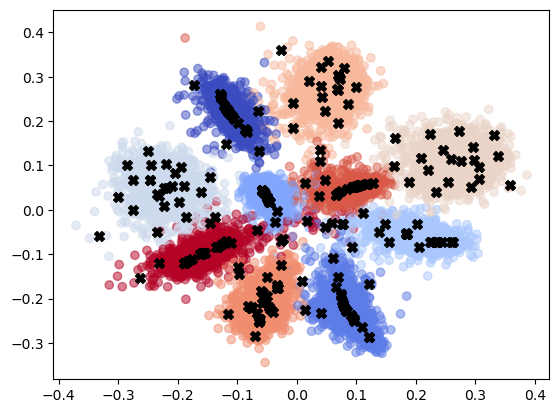

In [47]:
# Visualize the points in the feature space
plt.scatter(encoder(X_train)[:, 0], encoder(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(qkm_mnist2.qkm.c_x.numpy()[:, 0], qkm_mnist2.qkm.c_x.numpy()[:, 1], c='k', marker='X', s=50)
plt.show()

## Generator model

We can build a generator taking advantage of the symmetry of the QKM layer. Basically we change the role of the x-prototypes and the y-prototypes. The entry to the model will be a 10D vector that represents probability distribution of the digits to generate . The output of the QKM layer will be a probability distribution on the latent space. We can sample from this distribution to generate new samples that we will decode to obtain the generated digit. First we will train a decoder.

In [31]:

def create_decoder(base_depth, encoded_size):
    decoder = tf.keras.Sequential([
        tfkl.InputLayer(input_shape=[encoded_size]),
        tfkl.Reshape([1, 1, encoded_size]),
        tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                            padding='valid', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                    padding='same', activation=None),
    ])
    return decoder

decoder = create_decoder(base_depth, encoded_size)
inputs = tf.keras.layers.Input(shape=input_shape)
ae_model = tf.keras.Sequential([inputs,
                            encoder,
                            decoder                            
                           ])
encoder.trainable = False

ae_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
            loss=losses.BinaryCrossentropy(from_logits=True))

ae_model.fit(X_train, X_train, epochs=20, batch_size=32, verbose=0)

2023-06-13 16:58:26.351711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Let's plot some generated digits. The digits generated from the autoencoder are fuzzy because of the small dimension of the latent space. 

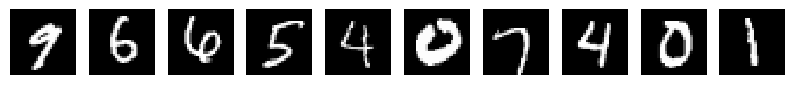

2023-06-13 17:01:01.510893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 338ms/step


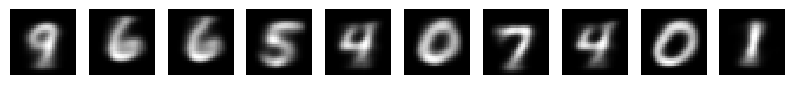

In [32]:
display_imgs(X_test[20:30])
prediction = ae_model.predict(X_test[20:30])

prediction = tf.nn.sigmoid(prediction)
display_imgs(prediction)

Now we define the generator model. It receives a 10D vector that represents the probability distribution of the digits to generate. The output of the QKM layer is a probability distribution on the latent space. We can sample from this distribution to generate new samples that we will decode to obtain the generated digit. 

In [34]:
from qkm.tf.layers import CosineKernelLayer, QKMLayer

def create_generator_model(clf_model):
        inputs_gen = Input(shape=(10,))
        kernel_gen = CosineKernelLayer()
        qkm_gen = QKMLayer(kernel=kernel_gen, 
                                   dim_x=10, 
                                   dim_y=clf_model.encoded_size, 
                                   n_comp=clf_model.n_comp)
        qkm_gen.c_x.assign(clf_model.qkm.c_y)
        qkm_gen.c_y.assign(clf_model.qkm.c_x)
        qkm_gen.c_w.assign(clf_model.qkm.c_w)
        rho_y_gen = qkm.tf.utils.pure2dm(inputs_gen)
        rho_x_gen = qkm_gen(rho_y_gen)
        gen_model = Model(inputs_gen, rho_x_gen)
        return gen_model

gen_model = create_generator_model(qkm_mnist2)
gen_model.compile()

2023-06-13 17:12:56.491428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


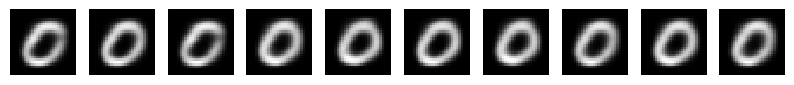

2023-06-13 17:12:57.133705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


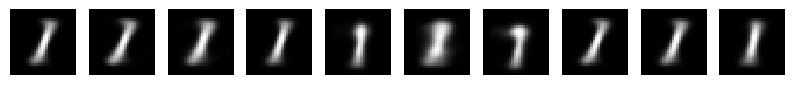

2023-06-13 17:12:57.658509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


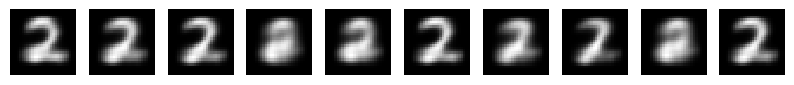

2023-06-13 17:12:58.226324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


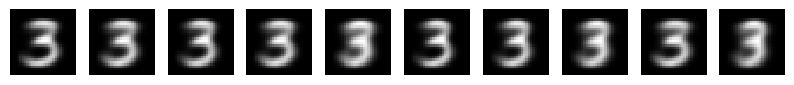

2023-06-13 17:12:58.744302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


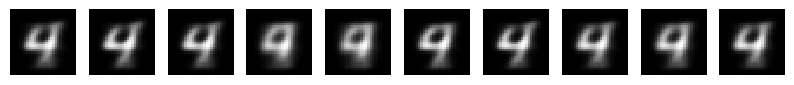

2023-06-13 17:12:59.492433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


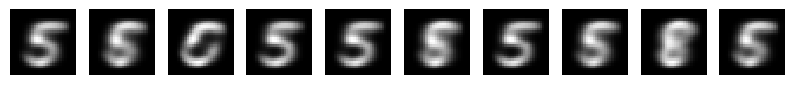

2023-06-13 17:13:00.043485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


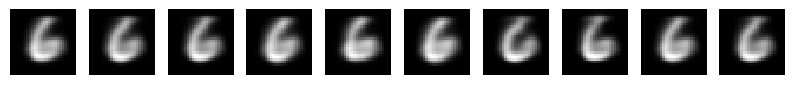

2023-06-13 17:13:00.567671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


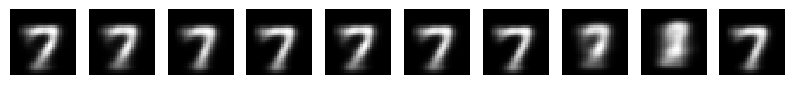

2023-06-13 17:13:01.119363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


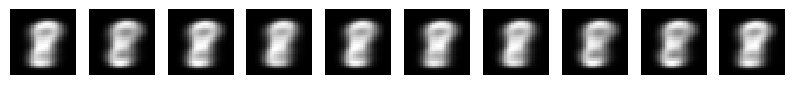

2023-06-13 17:13:01.649403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


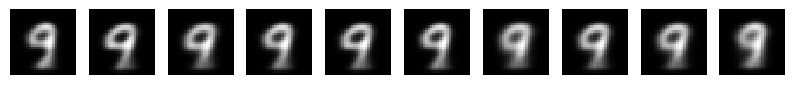

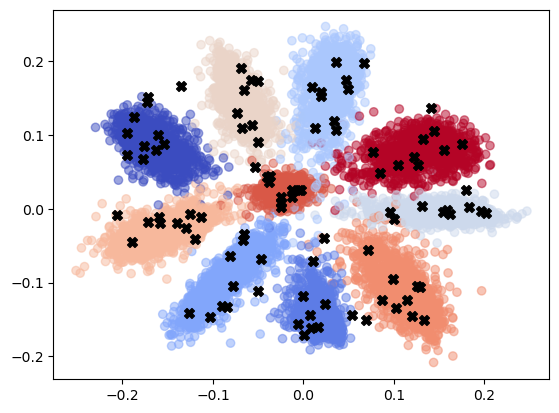

In [37]:
# Generate a set of distributions from the model for each digit
distribs = qkm.tf.utils.dm2distrib(gen_model(tf.eye(10)), sigma=qkm_mnist2.kernel.sigma * 1.5)
# Sample from the distributions
samples = []
for i in range(10):
    sample = distribs[i].sample(10).numpy()
    samples.append(sample)
    # Show the decoded images
    decoded_imgs = decoder(sample)
    decoded_imgs = tf.nn.sigmoid(decoded_imgs)
    display_imgs(decoded_imgs)

# plot the samples in the feature space
samples = np.concatenate(samples)
plt.scatter(encoder(X_train)[:, 0], encoder(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)
plt.scatter(samples[:, 0], samples[:, 1], c='k', marker='X', s=50)


Now we will generate digits from a label distribution that is a mixture of two digits. We will generate digits that are a mixture of 0 and 1. 

2023-06-13 17:19:18.386169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


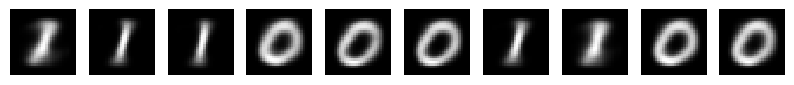

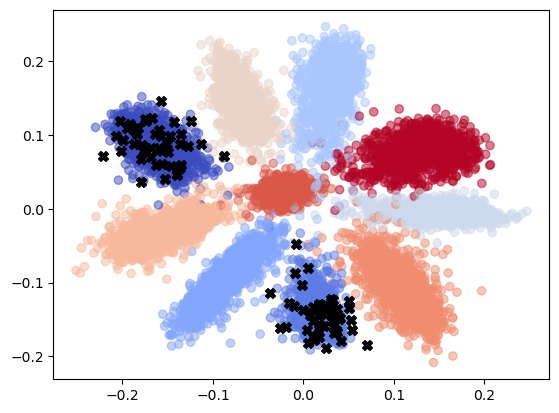

In [41]:
# Generate a set of distributions from the model for each digit
y_distrib = np.zeros((1,10))
y_distrib[0, 0] = 1 / np.sqrt(2)
y_distrib[0, 1] = 1 / np.sqrt(2)
x_distrib = qkm.tf.utils.dm2distrib(gen_model(y_distrib), sigma=qkm_mnist2.kernel.sigma * 1.5)[0]
# Sample from the distributions
sample = x_distrib.sample(100).numpy()
# Show the decoded images
decoded_imgs = decoder(sample[:10])
decoded_imgs = tf.nn.sigmoid(decoded_imgs)
display_imgs(decoded_imgs)

# plot the samples in the feature space
plt.scatter(encoder(X_train)[:, 0], encoder(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)
plt.scatter(sample[:, 0], sample[:, 1], c='k', marker='X', s=50)
